In [1]:
import os
import json
import torch
import torch.nn.functional as F
from transformer_lens import (
    HookedTransformer,
)

import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt

/home/yushi/anaconda3/envs/toxicity/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fig_utils import load_hooked

torch.set_grad_enabled(False)

In [2]:
# def convert(orig_state_dict, cfg):
#     state_dict = {}

#     state_dict["embed.W_E"] = orig_state_dict["transformer.wte.weight"]
#     state_dict["pos_embed.W_pos"] = orig_state_dict["transformer.wpe.weight"]

#     for l in range(cfg.n_layers):
#         state_dict[f"blocks.{l}.ln1.w"] = orig_state_dict[
#             f"transformer.h.{l}.ln_1.weight"
#         ]
#         state_dict[f"blocks.{l}.ln1.b"] = orig_state_dict[
#             f"transformer.h.{l}.ln_1.bias"
#         ]

#         # In GPT-2, q,k,v are produced by one big linear map, whose output is
#         # concat([q, k, v])
#         W = orig_state_dict[f"transformer.h.{l}.attn.c_attn.weight"]
#         W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=1)
#         W_Q = einops.rearrange(W_Q, "m (i h)->i m h", i=cfg.n_heads)
#         W_K = einops.rearrange(W_K, "m (i h)->i m h", i=cfg.n_heads)
#         W_V = einops.rearrange(W_V, "m (i h)->i m h", i=cfg.n_heads)

#         state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
#         state_dict[f"blocks.{l}.attn.W_K"] = W_K
#         state_dict[f"blocks.{l}.attn.W_V"] = W_V

#         qkv_bias = orig_state_dict[f"transformer.h.{l}.attn.c_attn.bias"]
#         qkv_bias = einops.rearrange(
#             qkv_bias,
#             "(qkv index head)->qkv index head",
#             qkv=3,
#             index=cfg.n_heads,
#             head=cfg.d_head,
#         )
#         state_dict[f"blocks.{l}.attn.b_Q"] = qkv_bias[0]
#         state_dict[f"blocks.{l}.attn.b_K"] = qkv_bias[1]
#         state_dict[f"blocks.{l}.attn.b_V"] = qkv_bias[2]

#         W_O = orig_state_dict[f"transformer.h.{l}.attn.c_proj.weight"]
#         W_O = einops.rearrange(W_O, "(i h) m->i h m", i=cfg.n_heads)
#         state_dict[f"blocks.{l}.attn.W_O"] = W_O
#         state_dict[f"blocks.{l}.attn.b_O"] = orig_state_dict[
#             f"transformer.h.{l}.attn.c_proj.bias"
#         ]

#         state_dict[f"blocks.{l}.ln2.w"] = orig_state_dict[
#             f"transformer.h.{l}.ln_2.weight"
#         ]
#         state_dict[f"blocks.{l}.ln2.b"] = orig_state_dict[
#             f"transformer.h.{l}.ln_2.bias"
#         ]

#         W_in = orig_state_dict[f"transformer.h.{l}.mlp.c_fc.weight"]
#         state_dict[f"blocks.{l}.mlp.W_in"] = W_in
#         state_dict[f"blocks.{l}.mlp.b_in"] = orig_state_dict[
#             f"transformer.h.{l}.mlp.c_fc.bias"
#         ]

#         W_out = orig_state_dict[f"transformer.h.{l}.mlp.c_proj.weight"]
#         state_dict[f"blocks.{l}.mlp.W_out"] = W_out
#         state_dict[f"blocks.{l}.mlp.b_out"] = orig_state_dict[
#             f"transformer.h.{l}.mlp.c_proj.bias"
#         ]
#     state_dict["unembed.W_U"] = orig_state_dict["lm_head.weight"].T

#     state_dict["ln_final.w"] = orig_state_dict["transformer.ln_f.weight"]
#     state_dict["ln_final.b"] = orig_state_dict["transformer.ln_f.bias"]
#     return state_dict

In [3]:
# def load_hooked(model_name, weights_path):
#     _model = HookedTransformer.from_pretrained(model_name)
#     cfg = _model.cfg

#     _weights = torch.load(weights_path, map_location=torch.device("cuda"))[
#         "state"
#     ]
#     weights = convert(_weights, cfg)
#     model = HookedTransformer(cfg)
#     model.load_and_process_state_dict(weights)
#     model.tokenizer.padding_side = "left"
#     model.tokenizer.pad_token_id = model.tokenizer.eos_token_id
#     return model

In [3]:
ROOT_DIR = os.getcwd()
dpo_model = load_hooked(
    "gpt2-medium",
    os.path.join(ROOT_DIR, "dpo.pt"),
)

gpt2 = HookedTransformer.from_pretrained("gpt2-medium")
gpt2.tokenizer.padding_side = "left"
gpt2.tokenizer.pad_token_id = gpt2.tokenizer.eos_token_id

toxic_vector = torch.load(os.path.join(ROOT_DIR, "probe.pt"))

Loaded pretrained model gpt2-medium into HookedTransformer
Loaded pretrained model gpt2-medium into HookedTransformer


In [6]:
print(gpt2)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [4]:
# load data
with open(
    os.path.join(ROOT_DIR, "challenge_prompts.jsonl"), "r"
) as file_p:
    data = file_p.readlines()

prompts = [json.loads(x.strip())["prompt"] for x in data]

tokenized_prompts = dpo_model.to_tokens(prompts, prepend_bos=True).cuda()     

##### Input and output projection function

In [10]:
def compute_layer_toxic_projection_reduction(model, tokenized_prompts, toxic_vector, batch_size=64):

    # Dictionary to store hook data
    mlp_inputs = {}

    # Function to create a hook function for a specific layer
    def create_store_mlp_input_hook(layer_idx):
        def store_mlp_input_hook(module, inputs, outputs):
            mlp_inputs[layer_idx] = inputs[0].detach()
        return store_mlp_input_hook

    # Add the hooks to each MLP layer in the model
    for layer_idx, layer in enumerate(model.blocks):
        layer.mlp.register_forward_hook(create_store_mlp_input_hook(layer_idx))

    # Initialize dictionaries to store projections for all layers
    gpt2_input_projections = defaultdict(list)
    gpt2_output_projections = defaultdict(list)
    gpt2_projection_reductions = defaultdict(list)

    sample_size = tokenized_prompts.size(0)

    print("Computing MLP inputs and output projections...")
    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]

        # Clear the mlp_inputs dictionary before running the batch
        mlp_inputs.clear()

        for timestep in range(20): # generate 20 tokens
            with torch.inference_mode():
                _, cache = model.run_with_cache(batch)

            sampled = model.unembed(cache["ln_final.hook_normalized"]).argmax(-1)[:, -1]

            for layer_idx in range(len(model.blocks)):
                # Retrieve the input to the MLP stored by the hook
                x_token = mlp_inputs[layer_idx][:, -1, :] # at the last token position

                # Get the output after the MLP has been applied (before adding back to the residual stream)
                y_token = cache[f"blocks.{layer_idx}.hook_mlp_out"][:, -1, :] # [batch_size, d_model]

                # print(torch.norm(x_token), torch.norm(y_token))
                
                # Compute the projection onto the toxic vector for the MLP input and output
                input_projection = torch.matmul(x_token, toxic_vector) / torch.norm(toxic_vector) # [batch_size]
                output_projection = torch.matmul(y_token, toxic_vector) / torch.norm(toxic_vector) # [batch_size]

                # Store the mean projection values for this batch and layer
                gpt2_input_projections[layer_idx].extend(input_projection.tolist())
                gpt2_output_projections[layer_idx].extend(output_projection.tolist())

                # Compute the projection reduction (how much the MLP changes the toxic direction)
                projection_reduction = input_projection - output_projection
                gpt2_projection_reductions[layer_idx].extend(projection_reduction.tolist())

            batch = torch.concat([batch, sampled.unsqueeze(-1)], dim=-1)

    # Compute final average projections across all batches and tokens for each layer
    avg_input_projections = {layer_idx: np.mean(projections) for layer_idx, projections in gpt2_input_projections.items()}
    avg_output_projections = {layer_idx: np.mean(projections) for layer_idx, projections in gpt2_output_projections.items()}
    avg_projection_reductions = {layer_idx: np.mean(projections) for layer_idx, projections in gpt2_projection_reductions.items()}

    return avg_input_projections, avg_output_projections, avg_projection_reductions


In [11]:
avg_input_projections, avg_output_projections, avg_projection_reductions = compute_layer_toxic_projection_reduction(gpt2, tokenized_prompts, toxic_vector)
avg_input_projections_dpo, avg_output_projections_dpo, avg_projection_reductions_dpo = compute_layer_toxic_projection_reduction(dpo_model, tokenized_prompts, toxic_vector)

Computing MLP inputs and output projections...


100%|██████████| 19/19 [00:57<00:00,  3.04s/it]


Computing MLP inputs and output projections...


100%|██████████| 19/19 [01:01<00:00,  3.23s/it]


##### Disable top toxic value vectors and plot output projections

In [12]:
def scale_top_value_vectors(model, toxic_vector, topk_sorted_score, scale_factor=0):
    """
    Scales the value vectors of the MLPs based on the cosine similarity of the value vectors to a given toxic vector.
    
    Args:
        model (torch.nn.Module): The model being modified.
        toxic_vector (torch.Tensor): The vector to compare against for scaling.
        topk_sorted_score (int): The number of top vectors to scale.
        scale_factor (float): The factor by which to scale the selected vectors.
    
    Returns:
        torch.nn.Module: The modified model with scaled value vectors.
    """
    scores = []
    
    # Iterate through each layer of the model
    for layer_idx in range(len(model.blocks)):
        # Target the value vectors in the MLP
        value_vectors = model.blocks[layer_idx].mlp.W_out
        
        # Compute cosine similarities between the value vectors and the toxic vector
        cos_sims = F.cosine_similarity(value_vectors, toxic_vector.unsqueeze(0), dim=1)
        
        # Get the top k most similar value vectors
        _topk = cos_sims.topk(k=100)
        _values = [x.item() for x in _topk.values]
        _idxs = [x.item() for x in _topk.indices]
        topk = list(zip(_values, _idxs, [layer_idx] * _topk.indices.shape[0]))
        scores.extend(topk)

    # Sort the scores in descending order based on cosine similarity
    sorted_scores = sorted(scores, key=lambda x: x[0], reverse=True)
    
    # Select the top `topk_sorted_score` value vectors and scale them
    with torch.no_grad():
        for score in sorted_scores[:topk_sorted_score]:
            layer_idx, neuron_idx = score[2], score[1]
            print(f"Scaling vector at layer {layer_idx}, index {neuron_idx} by {scale_factor}")
            model.blocks[layer_idx].mlp.W_out[neuron_idx, :] *= scale_factor

    # Return the modified model
    return model

In [13]:
def scale_top_value_vectors_with_positive_activations(model, toxic_positive_acts_index_csv_path, topk_sorted_score, scale_factor=0):
    """
    Scales the value vectors with positive activations before DPO based on the ranks of their cosine similarity with the toxic probe.
    """

    # Load the sorted scores from the CSV
    sorted_scores_df = pd.read_csv(toxic_positive_acts_index_csv_path)
    
    # Select the top `topk_sorted_score` layer and neuron indices from the CSV
    top_layer_neuron_indices = sorted_scores_df.head(topk_sorted_score)
    
    # Scale the selected value vectors
    with torch.no_grad():
        for _, row in top_layer_neuron_indices.iterrows():
            layer_idx = row['layer_idx']
            neuron_idx = row['neuron_idx']
            print(f"Scaling vector at layer {layer_idx}, index {neuron_idx} by {scale_factor}")
            model.blocks[layer_idx].mlp.W_out[neuron_idx, :] *= scale_factor

    return model 


In [14]:
# Disable top 200 toxic value vectors
new_gpt2 = scale_top_value_vectors(gpt2, toxic_vector, 200, 0)

Scaling vector at layer 19, index 770 by 0
Scaling vector at layer 12, index 771 by 0
Scaling vector at layer 18, index 2669 by 0
Scaling vector at layer 13, index 668 by 0
Scaling vector at layer 16, index 255 by 0
Scaling vector at layer 12, index 882 by 0
Scaling vector at layer 19, index 1438 by 0
Scaling vector at layer 9, index 545 by 0
Scaling vector at layer 8, index 2854 by 0
Scaling vector at layer 3, index 3680 by 0
Scaling vector at layer 14, index 1958 by 0
Scaling vector at layer 7, index 1735 by 0
Scaling vector at layer 13, index 2258 by 0
Scaling vector at layer 11, index 1550 by 0
Scaling vector at layer 3, index 704 by 0
Scaling vector at layer 10, index 3477 by 0
Scaling vector at layer 13, index 1023 by 0
Scaling vector at layer 13, index 253 by 0
Scaling vector at layer 10, index 2936 by 0
Scaling vector at layer 0, index 2352 by 0
Scaling vector at layer 7, index 1916 by 0
Scaling vector at layer 3, index 3742 by 0
Scaling vector at layer 11, index 2844 by 0
Scal

In [25]:
# Disable top 200 toxic value vectors with positive activations
# new_gpt2 = scale_top_value_vectors_with_positive_activations(gpt2, './toxic_positive_acts_idxs.csv', 2000, 0)

Scaling vector at layer 19, index 770 by 0
Scaling vector at layer 12, index 771 by 0
Scaling vector at layer 18, index 2669 by 0
Scaling vector at layer 13, index 668 by 0
Scaling vector at layer 16, index 255 by 0
Scaling vector at layer 12, index 882 by 0
Scaling vector at layer 19, index 1438 by 0
Scaling vector at layer 8, index 2854 by 0
Scaling vector at layer 3, index 3680 by 0
Scaling vector at layer 14, index 1958 by 0
Scaling vector at layer 13, index 2258 by 0
Scaling vector at layer 11, index 1550 by 0
Scaling vector at layer 10, index 3477 by 0
Scaling vector at layer 0, index 2352 by 0
Scaling vector at layer 3, index 3742 by 0
Scaling vector at layer 11, index 4021 by 0
Scaling vector at layer 11, index 175 by 0
Scaling vector at layer 19, index 3341 by 0
Scaling vector at layer 16, index 603 by 0
Scaling vector at layer 11, index 2617 by 0
Scaling vector at layer 8, index 3200 by 0
Scaling vector at layer 19, index 2312 by 0
Scaling vector at layer 20, index 3210 by 0


In [15]:
print(new_gpt2.blocks[19].mlp.W_out[770, :])

tensor([-0., -0., 0.,  ..., 0., -0., 0.], device='cuda:0', requires_grad=True)


In [16]:
new_avg_input_projections, new_avg_output_projections, new_avg_projection_reductions = compute_layer_toxic_projection_reduction(new_gpt2, tokenized_prompts, toxic_vector)

Computing MLP inputs and output projections...


100%|██████████| 19/19 [01:01<00:00,  3.26s/it]


##### Plotting functions

In [5]:
def plot_two_layer_projections(layer_input_projections1, layer_output_projections1,
                           layer_input_projections2, layer_output_projections2):
    # Ensure all projection lists are sorted by layer index
    layers1 = sorted(layer_input_projections1.keys())
    layers2 = sorted(layer_input_projections2.keys())
    
    # Convert dictionaries to lists based on the sorted layers
    layer_input_projections1 = [layer_input_projections1[layer] for layer in layers1]
    layer_output_projections1 = [layer_output_projections1[layer] for layer in layers1]
    layer_input_projections2 = [layer_input_projections2[layer] for layer in layers2]
    layer_output_projections2 = [layer_output_projections2[layer] for layer in layers2]

    plt.figure(figsize=(10, 6))
    plt.plot(layers1, layer_input_projections1, label='Pre-DPO Input Projection', marker='o', linestyle='-', color='blue')
    plt.plot(layers1, layer_output_projections1, label='Pre-DPO Output Projection', marker='x', linestyle='--', color='orange')
    
    plt.plot(layers2, layer_input_projections2, label='DPO Input Projection', marker='o', linestyle='-', color='green')
    plt.plot(layers2, layer_output_projections2, label='DPO Output Projection', marker='x', linestyle='--', color='red')

    plt.title('Input and Output Projections Across Layers')
    plt.xlabel('Layer Index')
    plt.ylabel('Projection')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def plot_three_layer_projections(layer_input_projections1, layer_output_projections1,
                           layer_input_projections2, layer_output_projections2,
                           layer_input_projections3, layer_output_projections3):
    # Ensure all projection lists are sorted by layer index
    layers1 = sorted(layer_input_projections1.keys())
    layers2 = sorted(layer_input_projections2.keys())
    layers3 = sorted(layer_input_projections3.keys())
    
    # Convert dictionaries to lists based on the sorted layers
    layer_input_projections1 = [layer_input_projections1[layer] for layer in layers1]
    layer_output_projections1 = [layer_output_projections1[layer] for layer in layers1]
    layer_input_projections2 = [layer_input_projections2[layer] for layer in layers2]
    layer_output_projections2 = [layer_output_projections2[layer] for layer in layers2]
    layer_input_projections3 = [layer_input_projections3[layer] for layer in layers3]
    layer_output_projections3 = [layer_output_projections3[layer] for layer in layers3]

    plt.figure(figsize=(12, 8))
    
    # Plot first set of input and output projections
    plt.plot(layers1, layer_input_projections1, label='Pre-DPO Input Projection', marker='o', linestyle='-', color='blue')
    plt.plot(layers1, layer_output_projections1, label='Pre-DPO Output Projection', marker='x', linestyle='--', color='orange')
    
    # Plot second set of input and output projections
    plt.plot(layers2, layer_input_projections2, label='Disable Value Vector Input Projection', marker='o', linestyle='-', color='green')
    plt.plot(layers2, layer_output_projections2, label='Disable Value Vector Output Projection', marker='x', linestyle='--', color='red')
    
    # Plot third set of input and output projections
    plt.plot(layers3, layer_input_projections3, label='DPO Input Projection', marker='o', linestyle='-', color='purple')
    plt.plot(layers3, layer_output_projections3, label='DPO Output Projection', marker='x', linestyle='--', color='brown')

    plt.title('Input and Output Projections Across Layers')
    plt.xlabel('Layer Index')
    plt.ylabel('Projection')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def plot_three_layer_projections_output(layer_output_projections1,
                                        layer_output_projections2,
                                        layer_output_projections3):
    # Ensure all projection lists are sorted by layer index
    layers1 = sorted(layer_output_projections1.keys())
    layers2 = sorted(layer_output_projections2.keys())
    layers3 = sorted(layer_output_projections3.keys())
    
    # Convert dictionaries to lists based on the sorted layers
    layer_output_projections1 = [layer_output_projections1[layer] for layer in layers1]
    layer_output_projections2 = [layer_output_projections2[layer] for layer in layers2]
    layer_output_projections3 = [layer_output_projections3[layer] for layer in layers3]

    plt.figure(figsize=(12, 8))
    
    # Plot first set of output projections with increased line width
    plt.plot(layers1, layer_output_projections1, label='Before DPO', marker='x', linestyle='--', color='red', linewidth=2.5)
    
    # Plot second set of output projections with increased line width
    plt.plot(layers2, layer_output_projections2, label='Disable top 200 toxic neurons', marker='x', linestyle='--', color='orange', linewidth=2.5)
    
    # Plot third set of output projections with increased line width
    plt.plot(layers3, layer_output_projections3, label='After DPO', marker='x', linestyle='--', color='green', linewidth=2.5)

    # plt.title('Output projection per layer')
    plt.xlabel('MLP layer index', fontsize=20)
    plt.ylabel('Output projection per layer', fontsize=20)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.grid(True)
    plt.show()

In [8]:
def plot_two_layer_projections_output(layer_output_projections1,
                                 layer_output_projections2):
    # Ensure all projection lists are sorted by layer index
    layers1 = sorted(layer_output_projections1.keys())
    layers2 = sorted(layer_output_projections2.keys())
    
    # Convert dictionaries to lists based on the sorted layers
    layer_output_projections1 = [layer_output_projections1[layer] for layer in layers1]
    layer_output_projections2 = [layer_output_projections2[layer] for layer in layers2]

    plt.figure(figsize=(12, 8))
    
    # Plot first set of output projections
    plt.plot(layers1, layer_output_projections1, label='Pre-DPO Output Projection', marker='x', linestyle='--', color='red')
    
    # Plot second set of output projections
    plt.plot(layers2, layer_output_projections2, label='DPO Output Projection', marker='x', linestyle='--', color='green')

    plt.title('Output Projections Across Layers')
    plt.xlabel('Layer Index')
    plt.ylabel('Projection')
    plt.legend()
    plt.grid(True)
    plt.show()

##### Projection after disabling toxic value vectors

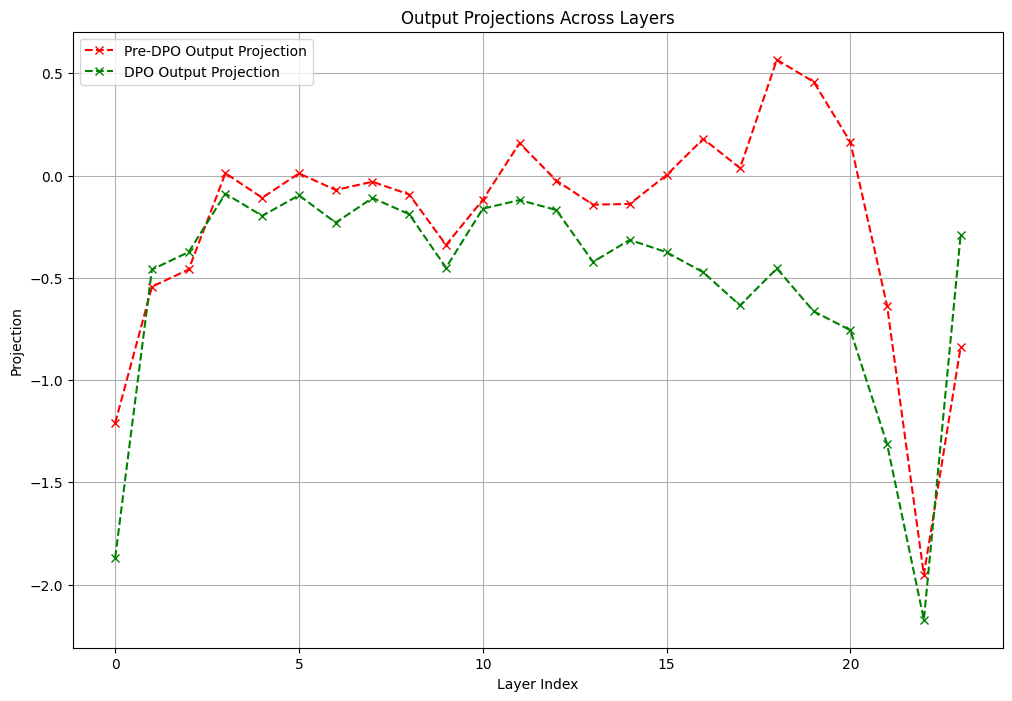

In [26]:
# Averaged over 20 tokens
plot_two_layer_projections_output(avg_output_projections, 
                      avg_output_projections_dpo)

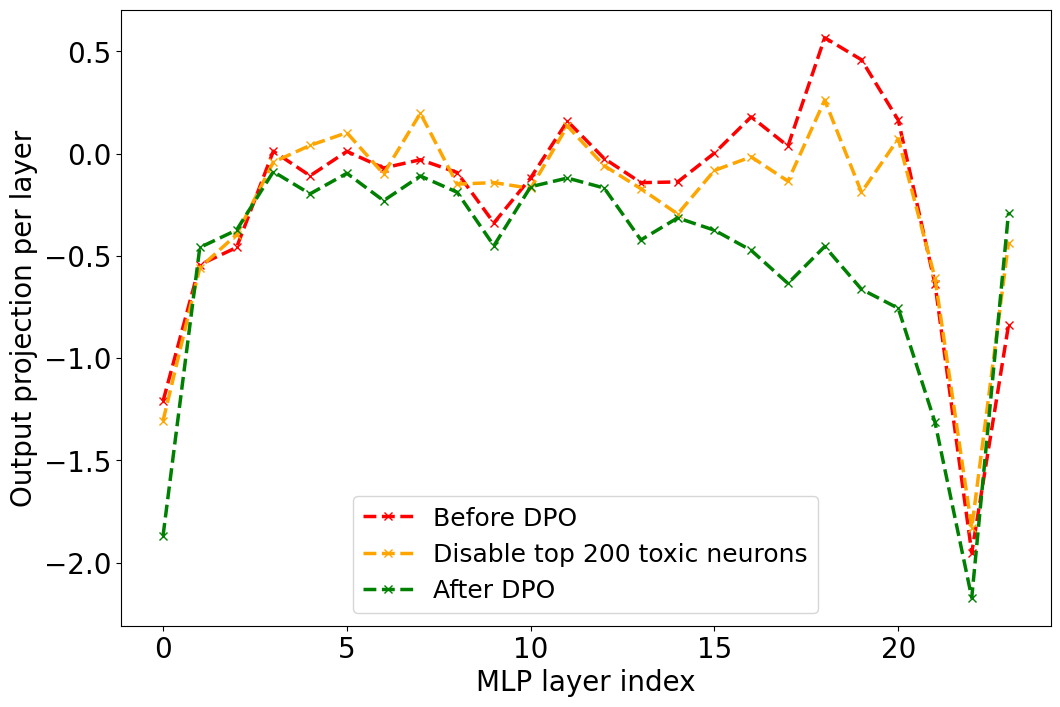

In [22]:
# Averaged over 20 tokens
# Disable top 200 value vectors
plot_three_layer_projections_output(avg_output_projections, 
                      new_avg_output_projections,
                      avg_output_projections_dpo)

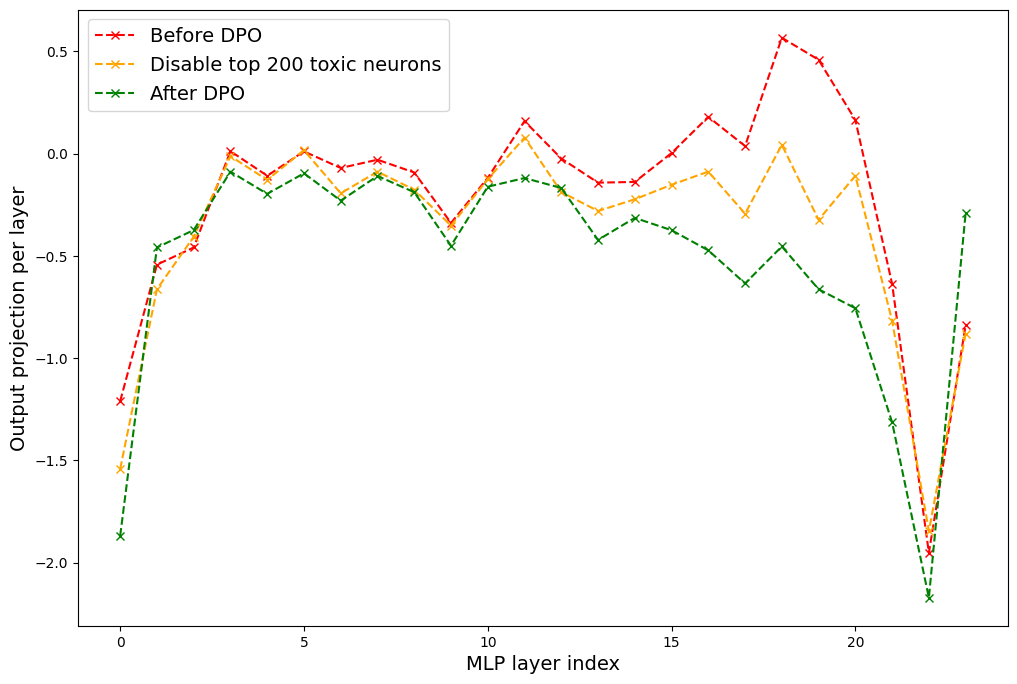

In [19]:
# Averaged over 20 tokens
# Disable top 200 value vectors with positive activations
plot_three_layer_projections_output(avg_output_projections, 
                      new_avg_output_projections,
                      avg_output_projections_dpo)

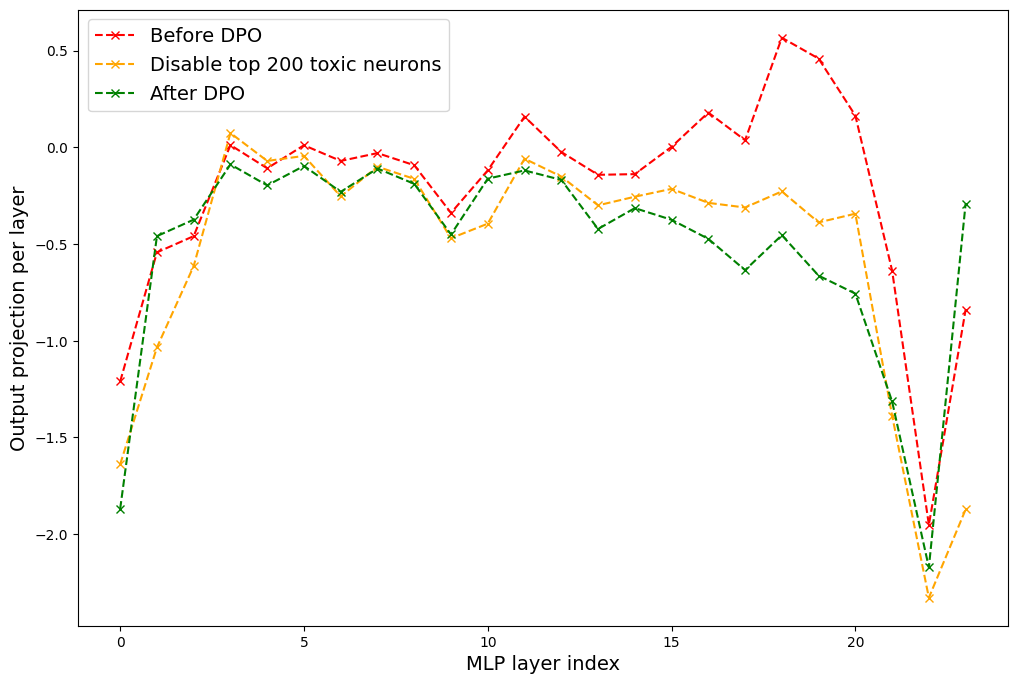

In [23]:
# Averaged over 20 tokens
# Disable top 1000 value vectors with positive activations (legend is wrong)
plot_three_layer_projections_output(avg_output_projections, 
                      new_avg_output_projections,
                      avg_output_projections_dpo)

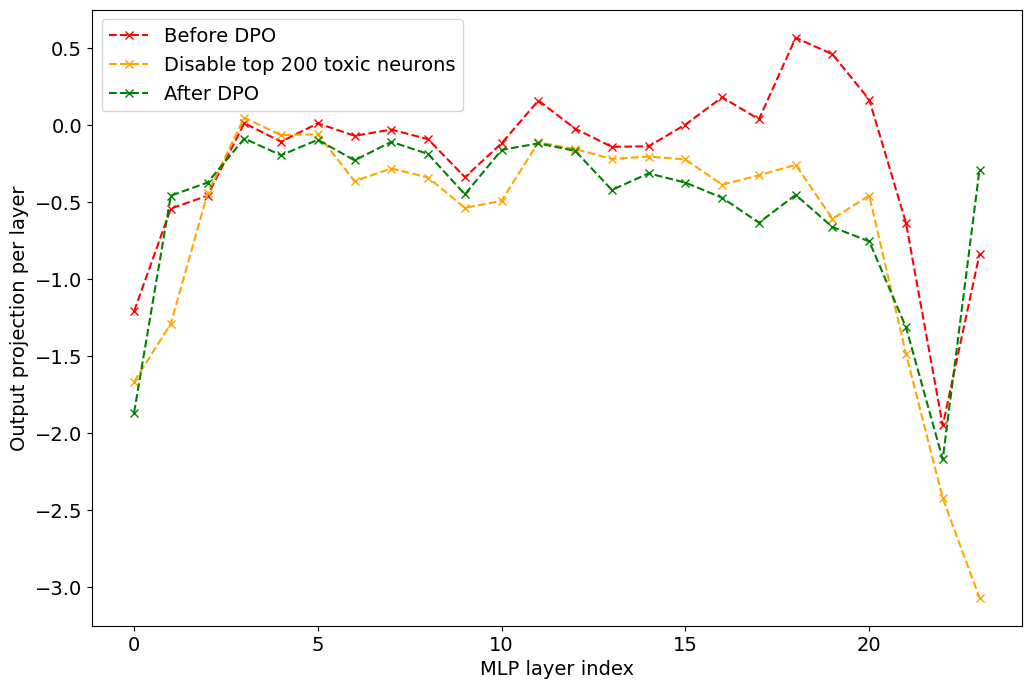

In [27]:
# Averaged over 20 tokens
# Disable top 2000 value vectors with positive activations (legend is wrong)
plot_three_layer_projections_output(avg_output_projections, 
                      new_avg_output_projections,
                      avg_output_projections_dpo)

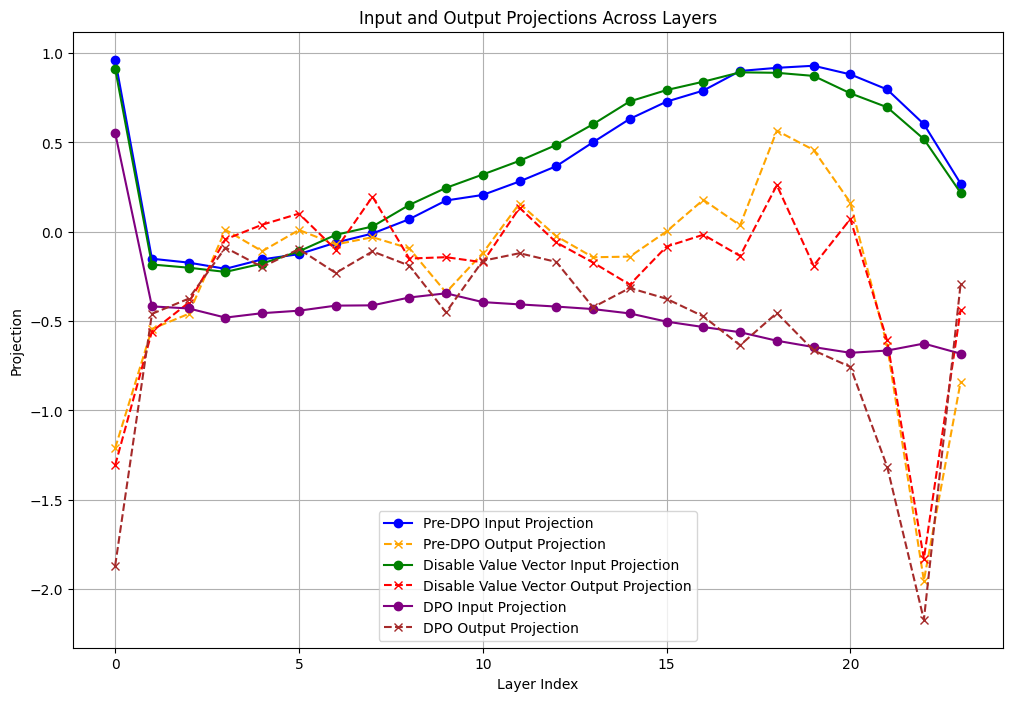

In [15]:
# Averaged over 20 tokens
# Disable top 200 value vectors
plot_three_layer_projections(avg_input_projections, avg_output_projections, 
                       new_avg_input_projections, new_avg_output_projections,
                       avg_input_projections_dpo, avg_output_projections_dpo)

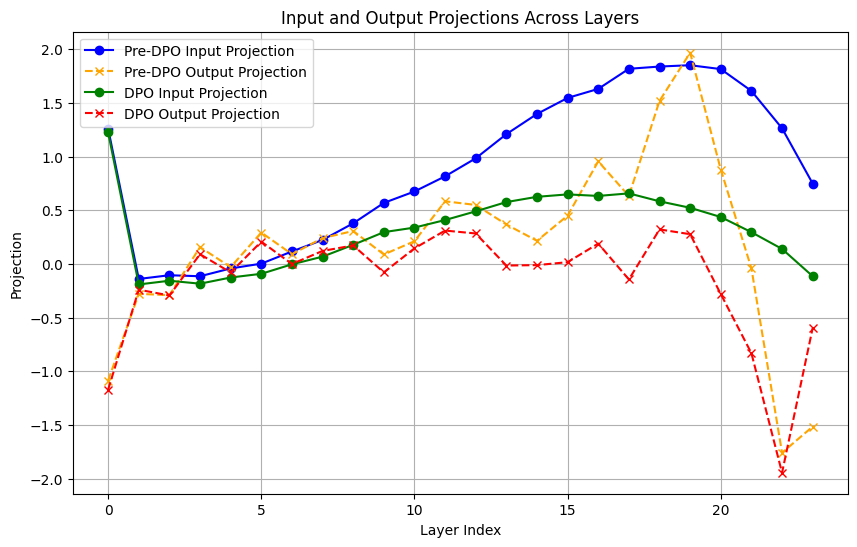

In [10]:
# At the last token position only (for generating the next token)
# Disable top 200 value vectors
plot_layer_projections(avg_input_projections, avg_output_projections, 
                       avg_input_projections_dpo, avg_output_projections_dpo)

##### Neuron toxicity projection function

In [16]:
def compute_neuron_toxic_projection(model, tokenized_prompts, toxic_vector, batch_size=64):
    # Initialize dictionaries to store projections and activations for all layers
    gpt2_neuron_projections = defaultdict(list)

    sample_size = tokenized_prompts.size(0)

    print("Computing MLP neuron projections...")
    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]

        for timestep in range(20):  # generate 20 tokens
            with torch.inference_mode():
                _, cache = model.run_with_cache(batch)

            sampled = model.unembed(cache["ln_final.hook_normalized"]).argmax(-1)[:, -1]

            for layer_idx in range(len(model.blocks)):
                # Extract neuron activations before applying the output weights
                neuron_acts = cache[f"blocks.{layer_idx}.mlp.hook_post"][:, -1, :]  # [batch_size, d_mlp]
                value_vectors = model.blocks[layer_idx].mlp.W_out  # [d_mlp, d_model]

                # Compute the neuron outputs by multiplying neuron_acts with the corresponding value vector
                neuron_outputs = neuron_acts.unsqueeze(-1) * value_vectors  # [batch_size, d_mlp, d_model]

                # Compute the projection onto the toxic vector for each neuron output
                neuron_projections = torch.matmul(neuron_outputs, toxic_vector) / torch.norm(toxic_vector)  # [batch_size, d_mlp]

                # Store the mean projection values and neuron activations for this batch, layer, and neuron
                for neuron_idx in range(neuron_projections.size(1)):
                    print(neuron_projections[:, neuron_idx].tolist())
                    gpt2_neuron_projections[(layer_idx, neuron_idx)].extend(neuron_projections[:, neuron_idx].tolist())

            batch = torch.concat([batch, sampled.unsqueeze(-1)], dim=-1)

    # Compute final average neuron projections and average activations across all batches and tokens 
    avg_neuron_projections = {
        (layer_idx, neuron_idx): np.mean(projections)
        for (layer_idx, neuron_idx), projections in gpt2_neuron_projections.items()
    }

    return avg_neuron_projections

##### Check neuron projection calculation correctness

In [43]:
def compute_layer_projection_sums(model, tokenized_prompts, toxic_vector, batch_size=64):
    # Initialize dictionaries to store the sum and count of projections for all layers
    gpt2_neuron_projections_sum = defaultdict(float)
    gpt2_neuron_projections_count = defaultdict(int)

    sample_size = tokenized_prompts.size(0)

    print("Computing MLP neuron projections and averaging them for each layer...")
    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]

        for timestep in range(20):  # generate 20 tokens
            with torch.inference_mode():
                _, cache = model.run_with_cache(batch)

            sampled = model.unembed(cache["ln_final.hook_normalized"]).argmax(-1)[:, -1]

            for layer_idx in range(len(model.blocks)):
                # Extract neuron activations before applying the output weights
                neuron_acts = cache[f"blocks.{layer_idx}.mlp.hook_post"][:, -1, :]  # [batch_size, d_mlp]
                value_vectors = model.blocks[layer_idx].mlp.W_out  # [d_mlp, d_model]

                # Compute the neuron outputs by multiplying neuron_acts with the corresponding value vector
                neuron_outputs = neuron_acts.unsqueeze(-1) * value_vectors  # [batch_size, d_mlp, d_model]

                # Compute the projection onto the toxic vector for each neuron output
                neuron_projections = torch.matmul(neuron_outputs, toxic_vector) / torch.norm(toxic_vector)  # [batch_size, d_mlp]
                
                # Sum the projections across all neurons in the layer for this batch
                layer_projection_sum = torch.sum(neuron_projections, dim=1)  # [batch_size]

                # Accumulate the sum of projections for the layer and keep track of the count
                gpt2_neuron_projections_sum[layer_idx] += torch.sum(layer_projection_sum).item()
                gpt2_neuron_projections_count[layer_idx] += batch_size

            # Update the batch with the newly sampled tokens
            batch = torch.concat([batch, sampled.unsqueeze(-1)], dim=-1)

    # Calculate the final averaged projection for each layer and add the bias projection
    final_layer_projections = {}
    for layer_idx in range(len(model.blocks)):
        # Average the accumulated projections
        avg_projection = gpt2_neuron_projections_sum[layer_idx] / gpt2_neuron_projections_count[layer_idx]
        
        # Add the bias projection
        bias = model.blocks[layer_idx].mlp.b_out  # [d_model]
        bias_projection = torch.dot(bias, toxic_vector) / torch.norm(toxic_vector)  # scalar

        # Final projection for this layer
        final_layer_projections[layer_idx] = avg_projection + bias_projection.item()

    return final_layer_projections

In [33]:
def plot_layer_projections(layer_projections):
    layers = list(layer_projections.keys())
    projections = list(layer_projections.values())

    plt.figure(figsize=(10, 6))
    plt.plot(layers, projections, marker='o', linestyle='-', color='b')
    plt.xlabel('Layer Index')
    plt.ylabel('Final Projection Sum')
    plt.title('Final Layer Projections for Each Layer')
    plt.grid(True)
    plt.show()

Computing MLP neuron projections and averaging them for each layer...


100%|██████████| 19/19 [01:17<00:00,  4.10s/it]


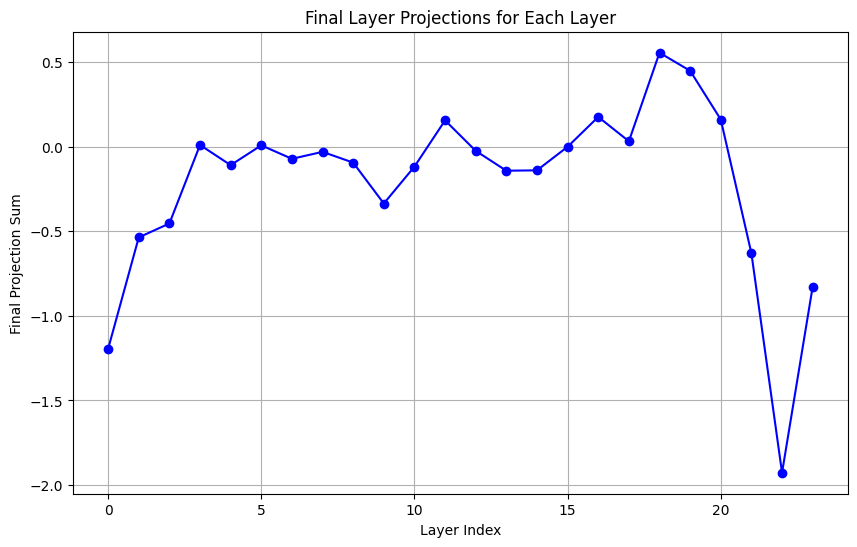

In [45]:
final_layer_projections = compute_layer_projection_sums(gpt2, tokenized_prompts, toxic_vector)
plot_layer_projections(final_layer_projections)

##### Compute neuron toxicity projections

In [17]:
# Save results to csv file
def save_neuron_projections_to_csv(avg_neuron_projections, filename):
    # Convert the dictionary to a list of tuples (layer_idx, neuron_idx, projection_value)
    data = [
        {"layer_idx": layer_idx, "neuron_idx": neuron_idx, "projection_value": projection}
        for (layer_idx, neuron_idx), projection in avg_neuron_projections.items()
    ]

    # Create a pandas DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"Neuron projections saved to {filename}")

In [18]:
# Compute the neuron data and average projections
avg_neuron_projections = compute_neuron_toxic_projection(gpt2, tokenized_prompts, toxic_vector)

Computing MLP neuron projections...


100%|██████████| 19/19 [12:21<00:00, 39.04s/it]


In [19]:
# Save to csv file
save_neuron_projections_to_csv(avg_neuron_projections, filename="gpt2_neuron_projections.csv")

Neuron projections saved to gpt2_neuron_projections.csv


In [20]:
# For the DPO-ed model
avg_neuron_projections_dpo = compute_neuron_toxic_projection(dpo_model, tokenized_prompts, toxic_vector)

Computing MLP neuron projections...


100%|██████████| 19/19 [12:17<00:00, 38.81s/it]


In [25]:
# Save to csv file
save_neuron_projections_to_csv(avg_neuron_projections_dpo, filename="dpo_neuron_projections.csv")

Neuron projections saved to dpo_neuron_projections.csv


In [16]:
# Top neuron contributors for each layer

# Step 1: Compute the difference in projections between the original model and DPO model
projection_diffs = {}

for (layer_idx, neuron_idx), proj in avg_neuron_projections.items():
    if (layer_idx, neuron_idx) in avg_neuron_projections_dpo:
        diff = proj - avg_neuron_projections_dpo[(layer_idx, neuron_idx)]
        if layer_idx not in projection_diffs:
            projection_diffs[layer_idx] = []
        projection_diffs[layer_idx].append((neuron_idx, diff))

# Step 2: Sort the differences within each layer to find the top neurons with the largest decrease
top_neurons_per_layer = {}

for layer_idx, neuron_diffs in projection_diffs.items():
    # Sort neurons by projection difference in descending order
    sorted_neurons = sorted(neuron_diffs, key=lambda x: x[1], reverse=True)
    # Select top neurons for this layer (you can choose the top N neurons per layer)
    top_neurons_per_layer[layer_idx] = sorted_neurons[:20]  # Adjust the number as needed

# Step 3: Retrieve the neuron activations before and after DPO for the top neurons in each layer
top_neuron_acts_per_layer = {}

for layer_idx, top_neurons in top_neurons_per_layer.items():
    top_neuron_acts_per_layer[layer_idx] = []
    for neuron_idx, diff in top_neurons:
        top_neuron_acts_per_layer[layer_idx].append({
            'layer_idx': layer_idx,
            'neuron_idx': neuron_idx,
            'projection_diff': diff,
        })

# Step 4: Print or return the top neuron information per layer
for layer_idx, neuron_acts in top_neuron_acts_per_layer.items():
    print(f"Layer {layer_idx}:")
    for neuron in neuron_acts:
        print(f"  Neuron {neuron['neuron_idx']}:")
        print(f"    Projection Decrease: {neuron['projection_diff']}")

Layer 0:
  Neuron 2352:
    Projection Decrease: 0.049452466105703724
  Neuron 3393:
    Projection Decrease: 0.04373906129613607
  Neuron 783:
    Projection Decrease: 0.014549007753007753
  Neuron 2816:
    Projection Decrease: 0.012614502230804733
  Neuron 19:
    Projection Decrease: 0.010531206104966802
  Neuron 1958:
    Projection Decrease: 0.010488150450260036
  Neuron 2275:
    Projection Decrease: 0.01018909732113531
  Neuron 2134:
    Projection Decrease: 0.009902343165464463
  Neuron 2937:
    Projection Decrease: 0.008155919152251183
  Neuron 3492:
    Projection Decrease: 0.007580381316840273
  Neuron 2827:
    Projection Decrease: 0.0070879923099752325
  Neuron 2450:
    Projection Decrease: 0.007050862367087047
  Neuron 3970:
    Projection Decrease: 0.00689809429705484
  Neuron 1254:
    Projection Decrease: 0.0063022980642905
  Neuron 1780:
    Projection Decrease: 0.005651099410819228
  Neuron 1469:
    Projection Decrease: 0.0051574934466962616
  Neuron 2872:
    Pr

In [24]:
# Top neuron contributors across all layers

# Step 1: Compute the difference in projections between the original model and DPO model
projection_diffs = {}

for (layer_idx, neuron_idx), proj in avg_neuron_projections.items():
    if (layer_idx, neuron_idx) in avg_neuron_projections_dpo:
        diff = proj - avg_neuron_projections_dpo[(layer_idx, neuron_idx)]
        projection_diffs[(layer_idx, neuron_idx)] = diff

# Step 2: Sort the differences to find the top neurons with the largest decrease
all_neurons_sorted = sorted(projection_diffs.items(), key=lambda x: x[1], reverse=True)

# Step 3: Retrieve the neuron activations before and after DPO for all neurons
all_neurons_projs = []

for (layer_idx, neuron_idx), diff in all_neurons_sorted:
    all_neurons_projs.append({
        'layer_idx': layer_idx,
        'neuron_idx': neuron_idx,
        'projection_diff': diff,
    })

# Step 4: Print or return the top 100 neuron information
for neuron in all_neurons_projs[:100]:
    print(f"Layer {neuron['layer_idx']}, Neuron {neuron['neuron_idx']}:")
    print(f"  Projection Decrease: {neuron['projection_diff']}")
    

Layer 19, Neuron 770:
  Projection Decrease: 0.3675263464612967
Layer 19, Neuron 1438:
  Projection Decrease: 0.19486256503416116
Layer 12, Neuron 882:
  Projection Decrease: 0.13995405819515722
Layer 18, Neuron 2669:
  Projection Decrease: 0.13651980709997258
Layer 16, Neuron 603:
  Projection Decrease: 0.12896373863144248
Layer 21, Neuron 2876:
  Projection Decrease: 0.11895102502483425
Layer 13, Neuron 668:
  Projection Decrease: 0.10795995673146282
Layer 20, Neuron 2953:
  Projection Decrease: 0.10417744677728302
Layer 21, Neuron 1404:
  Projection Decrease: 0.09772391342438909
Layer 20, Neuron 2820:
  Projection Decrease: 0.09671118166907666
Layer 12, Neuron 771:
  Projection Decrease: 0.09032603263893851
Layer 15, Neuron 4051:
  Projection Decrease: 0.08865186790371354
Layer 20, Neuron 3210:
  Projection Decrease: 0.08773188813315774
Layer 21, Neuron 3336:
  Projection Decrease: 0.08414752618237109
Layer 23, Neuron 4039:
  Projection Decrease: 0.07541508153628246
Layer 22, Neuron

##### Compute (value_vector * toxic direction)

In [8]:
# Compute the dot product of value vectors with the normalized toxic vector
def compute_all_value_vector_projection(model, toxic_vector, model_name="model"):
    value_vector_projections = []

    # Normalize the toxic vector
    normalized_toxic_vector = toxic_vector / toxic_vector.norm()

    # Iterate over all layers and all neurons in each layer
    for layer_idx in range(len(model.blocks)):
        # Get the weight matrix W_out for the current layer's MLP
        W_out = model.blocks[layer_idx].mlp.W_out  # [d_mlp, d_model]

        for neuron_idx in range(W_out.shape[0]):
            # Get the value vector for the specified neuron
            value_vector = W_out[neuron_idx]  # [d_model]

            # Compute the dot product between the value vector and the normalized toxic vector
            value_vector_projection = torch.dot(value_vector, normalized_toxic_vector).item()

            # Store the layer index, neuron index, and computed projection
            value_vector_projections.append({
                "layer_idx": layer_idx,
                "neuron_idx": neuron_idx,
                "value_vector_projection": value_vector_projection
            })
    
    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(value_vector_projections)

    # Generate the CSV filename using the model name
    csv_filename = f"{model_name}_value_vector_projections.csv"

    # Save the DataFrame to a CSV file with the generated filename
    df.to_csv(csv_filename, index=False)
    print(f"Projections saved to {csv_filename}")

    return df

In [9]:
df_gpt2 = compute_all_value_vector_projection(gpt2, toxic_vector, model_name="gpt2")

Projections saved to value_vector_projections_gpt2.csv


In [10]:
df_dpo = compute_all_value_vector_projection(dpo_model, toxic_vector, model_name="dpo")

Projections saved to value_vector_projections_dpo.csv


##### Extract all cossims of neurons

In [5]:
# Compute cossims of all neurons - very similar before and after DPO
def compute_all_neuron_cossims(model, toxic_vector, model_name="model"):
    gpt2_neuron_cossims = []

    # Iterate over all layers and all neurons in each layer
    for layer_idx in range(len(model.blocks)):
        # Get the weight matrix W_out for the current layer's MLP
        W_out = model.blocks[layer_idx].mlp.W_out  # [d_mlp, d_model]

        for neuron_idx in range(W_out.shape[0]):
            # Get the value vector for the specified neuron
            value_vector = W_out[neuron_idx]  # [d_model]

            # Compute the cosine similarity between the value vector and the toxic vector
            cossim = F.cosine_similarity(value_vector.unsqueeze(0), toxic_vector.unsqueeze(0), dim=1).item()

            # Store the layer index, neuron index, and computed cosine similarity
            gpt2_neuron_cossims.append({
                "layer_idx": layer_idx,
                "neuron_idx": neuron_idx,
                "cosine_similarity": cossim
            })
    
    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(gpt2_neuron_cossims)

    # Generate the CSV filename using the model name
    csv_filename = f"{model_name}_neuron_cossims.csv"

    # Save the DataFrame to a CSV file with the generated filename
    df.to_csv(csv_filename, index=False)
    print(f"Cosine similarities saved to {csv_filename}")

    return df

In [6]:
df_gpt2 = compute_all_neuron_cossims(gpt2, toxic_vector, model_name = 'gpt2')

Cosine similarities saved to neuron_cossims_gpt2.csv


In [7]:
df_dpo = compute_all_neuron_cossims(dpo_model, toxic_vector, model_name = 'dpo')

Cosine similarities saved to neuron_cossims_dpo.csv


In [20]:
top_100_neurons_indexes = [(19, 770), (19, 1438), (12, 882), (18, 2669), (16, 603), (21, 2876), (13, 668), (20, 2953), (21, 1404), (20, 2820), (12, 771), (15, 4051), (20, 3210), (21, 3336), (23, 4039), (22, 1406), (18, 2757), (18, 2062), (11, 175), (16, 3941), (23, 816), (18, 919), (3, 3680), (6, 3972), (23, 1295), (21, 2568), (21, 3929), (17, 368), (17, 3922), (13, 33), (19, 3341), (19, 2312), (18, 430), (21, 566), (13, 2258), (3, 3742), (8, 2854), (21, 387), (16, 255), (18, 2795), (20, 539), (0, 2352), (14, 1958), (19, 2191), (17, 3704), (20, 3384), (20, 474), (11, 1550), (20, 1748), (0, 3393), (18, 3606), (21, 1889), (17, 2875), (23, 3759), (20, 3773), (20, 2780), (23, 505), (14, 883), (17, 359), (22, 4077), (13, 3243), (16, 1291), (10, 3184), (22, 782), (18, 2982), (21, 3088), (19, 505), (17, 3336), (23, 2031), (23, 1054), (22, 1075), (21, 2318), (19, 1402), (15, 3116), (16, 2492), (17, 3162), (19, 955), (23, 4069), (19, 3244), (22, 3559), (23, 1029), (23, 1874), (23, 2954), (16, 1800), (10, 3477), (19, 2006), (22, 3980), (20, 2946), (23, 2220), (21, 3774), (23, 1268), (22, 2308), (22, 1418), (23, 1274), (17, 346), (15, 1517), (22, 268), (18, 1971), (11, 4021), (20, 1483)]

In [17]:
def compute_top_neuron_cossims(model, toxic_vector, top_neurons):
    gpt2_neuron_cossims = []

    for layer_idx, neuron_idx in top_neurons:
        # Get the value vector for the specified layer and neuron
        value_vector = model.blocks[layer_idx].mlp.W_out[neuron_idx] # [d_model]
        
        # Compute the cosine similarity between the value vector and the toxic vector
        cossim = F.cosine_similarity(value_vector.unsqueeze(0), toxic_vector.unsqueeze(0), dim=1).item()
        
        # Append the result to the list
        gpt2_neuron_cossims.append(cossim)
    
    return gpt2_neuron_cossims

In [22]:
top_neuron_cossims = compute_top_neuron_cossims(gpt2, toxic_vector, top_100_neurons_indexes)

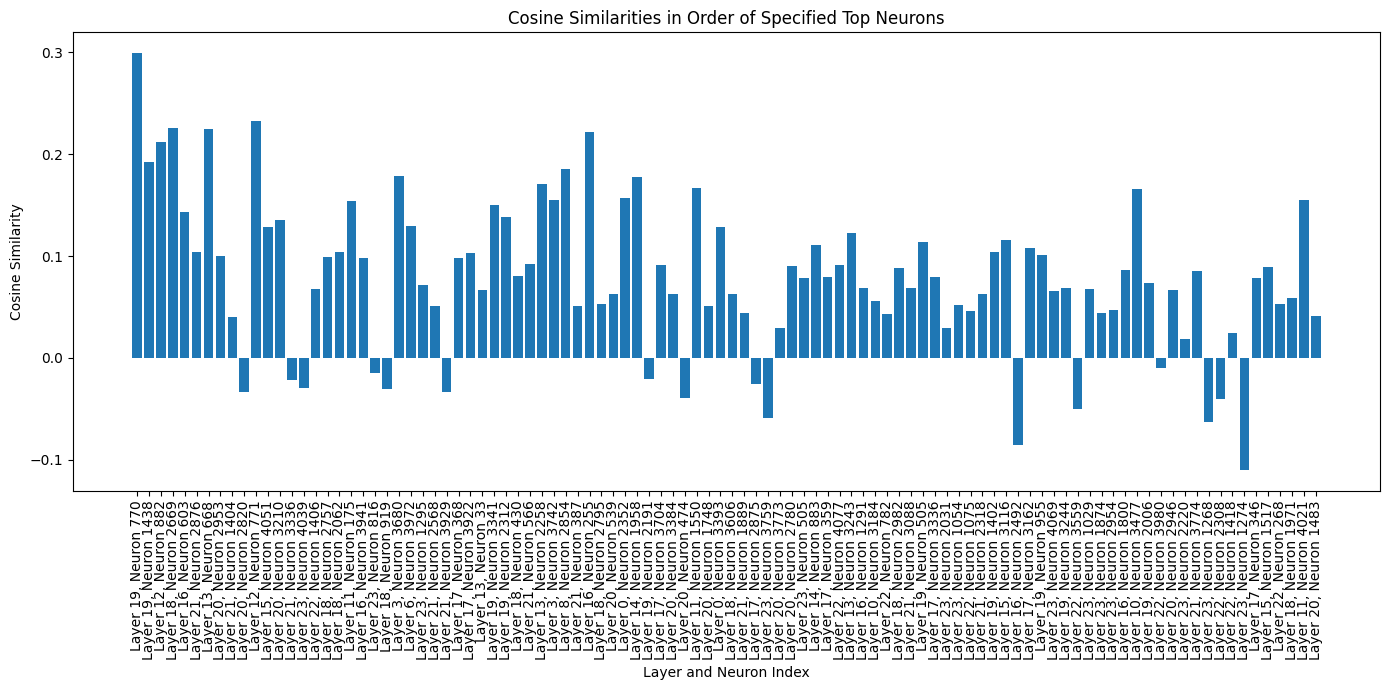

In [25]:
# Prepare labels for the x-axis
labels = [f"Layer {layer}, Neuron {neuron}" for layer, neuron in top_100_neurons_indexes]

# Plotting the cossims
plt.figure(figsize=(14, 7))
plt.bar(labels, top_neuron_cossims)

# Adding labels and title
plt.xlabel("Layer and Neuron Index")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarities in Order of Specified Top Neurons")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()
plt.show()

##### Compute (after-GELU) activations pre-DPO and post-DPO for all neurons

In [6]:
def compute_top_neuron_acts(model, tokenized_prompts, batch_size=64):
    # Initialize dictionaries to store activations for all neurons
    gpt2_neuron_acts = defaultdict(list)

    sample_size = tokenized_prompts.size(0)

    print("Computing MLP neuron activations...")
    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]

        for timestep in range(20):  # generate 20 tokens
            with torch.inference_mode():
                _, cache = model.run_with_cache(batch)

            sampled = model.unembed(cache["ln_final.hook_normalized"]).argmax(-1)[:, -1]

            for layer_idx in range(len(model.blocks)):
                # Extract (after Gelu) neuron activations before applying the output weights
                neuron_acts = cache[f"blocks.{layer_idx}.mlp.hook_post"][:, -1, :]  # [batch_size, d_mlp]

                # Store the neuron activations for this batch, layer, and neuron
                for neuron_idx in range(neuron_acts.size(1)):
                    gpt2_neuron_acts[(layer_idx, neuron_idx)].extend(neuron_acts[:, neuron_idx].tolist())

            batch = torch.concat([batch, sampled.unsqueeze(-1)], dim=-1)

    # Compute final average neuron activations across all batches and tokens
    avg_neuron_acts = {
        (layer_idx, neuron_idx): np.mean(acts)
        for (layer_idx, neuron_idx), acts in gpt2_neuron_acts.items()
    }

    return avg_neuron_acts

In [7]:
# Save results to csv file
def save_neuron_acts_to_csv(avg_neuron_acts, filename):
    # Convert the dictionary to a list of tuples (layer_idx, neuron_idx, acts)
    data = [
        {"layer_idx": layer_idx, "neuron_idx": neuron_idx, "activation": acts}
        for (layer_idx, neuron_idx), acts in avg_neuron_acts.items()
    ]

    # Create a pandas DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"Neuron activations saved to {filename}")

In [8]:
# Compute the neuron acts before DPO
avg_neuron_acts = compute_top_neuron_acts(gpt2, tokenized_prompts)

Computing MLP neuron projections, activations, and cosine similarities...


100%|██████████| 19/19 [11:34<00:00, 36.57s/it]


In [9]:
# Save to csv file
save_neuron_acts_to_csv(avg_neuron_acts, filename="gpt2_neuron_activations.csv")

Neuron activations saved to gpt2_neuron_activations.csv


In [10]:
# Compute the neuron acts after DPO
avg_neuron_acts_dpo = compute_top_neuron_acts(dpo_model, tokenized_prompts)

Computing MLP neuron projections, activations, and cosine similarities...


 47%|████▋     | 9/19 [05:06<06:00, 36.01s/it]

In [ ]:
# Save to csv file
save_neuron_acts_to_csv(avg_neuron_acts_dpo, filename="dpo_neuron_activations.csv")

Neuron activations saved to dpo_neuron_activations.csv


##### Compute (pre-GELU) activations pre-DPO and post-DPO for all neurons

In [2]:
import math

def gelu(x):
    """Compute the GELU function."""
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))

def inverse_gelu(output, epsilon=1e-5, max_iter=100):
    """Approximate the inverse of the GELU function."""
    # Start with an initial guess for the input
    x = output
    for _ in range(max_iter):
        # Compute the output of GELU for the current guess
        gelu_output = gelu(x)
        
        # Calculate the derivative of GELU at current guess
        derivative = 0.5 * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3)))) \
                   + 0.5 * x * (1 / math.cosh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3)))) ** 2 \
                   * (math.sqrt(2 / math.pi) * (1 + 0.134145 * (x ** 2)))
        
        # Update the guess using Newton's method
        x -= (gelu_output - output) / derivative
        
        # Stop if the guess is close enough to the actual input
        if abs(gelu_output - output) < epsilon:
            break
    return x

# Example usage
output_value = gelu(-0.2769)
input_value = inverse_gelu(output_value)
print(f"GELU Output: {output_value}")
print(f"Inverse GELU Input: {input_value}")


GELU Output: -0.10824992063661397
Inverse GELU Input: -0.2768999999987656


In [7]:
df = pd.read_csv('/code/eraser_neurons/all_neuron_metrics.csv')

# Apply the inverse GELU function to the 'dpo_activation' column
df['dpo_pregelu_activation'] = df['dpo_activation'].apply(inverse_gelu)

# Display the updated DataFrame
print(df.head)

df.to_csv('/code/eraser_neurons/all_neuron_metrics.csv', index=False)

<bound method NDFrame.head of        layer_idx  neuron_idx  gpt2_projection  dpo_projection  \
0              0           0        -0.004434       -0.004821   
1              0           1         0.000381        0.000381   
2              0           2         0.008536        0.008656   
3              0           3         0.004260        0.004129   
4              0           4         0.000003       -0.000003   
...          ...         ...              ...             ...   
98299         23        4091         0.000660        0.000543   
98300         23        4092        -0.018363       -0.012239   
98301         23        4093         0.004632        0.004117   
98302         23        4094        -0.000759       -0.003243   
98303         23        4095         0.000073       -0.000018   

       gpt2_activation  dpo_activation  gpt2_cossim  dpo_cossim  \
0            -0.086628       -0.094152     0.020808    0.020818   
1            -0.010077       -0.010096    -0.015356   -

In [1]:
import torch

# Define the values for which we want to compute the GeLU
values = torch.tensor([1.7812614, 3.557839])

# Compute GeLU using PyTorch's built-in function
gelu_values = torch.nn.functional.gelu(values)

gelu_values


tensor([1.7146, 3.5572])

##### Compute post-Gelu activation at only the last time step (for activation patching)

In [2]:
def compute_top_neuron_acts(model, tokenized_prompts, batch_size=64):
    # Initialize dictionaries to store activations for all neurons
    gpt2_neuron_acts = defaultdict(list)

    sample_size = tokenized_prompts.size(0)

    print("Computing MLP neuron activations...")
    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]
        
        with torch.inference_mode():
            _, cache = model.run_with_cache(batch)

        sampled = model.unembed(cache["ln_final.hook_normalized"]).argmax(-1)[:, -1] # generate the next token only

        for layer_idx in range(len(model.blocks)):
            # Extract (after Gelu) neuron activations before applying the output weights
            neuron_acts = cache[f"blocks.{layer_idx}.mlp.hook_post"][:, -1, :]  # [batch_size, d_mlp]

            # Store the neuron activations for this batch, layer, and neuron
            for neuron_idx in range(neuron_acts.size(1)):
                gpt2_neuron_acts[(layer_idx, neuron_idx)].extend(neuron_acts[:, neuron_idx].tolist())

        batch = torch.concat([batch, sampled.unsqueeze(-1)], dim=-1)

    # Compute final average neuron activations across all batches and tokens
    avg_neuron_acts = {
        (layer_idx, neuron_idx): np.mean(acts)
        for (layer_idx, neuron_idx), acts in gpt2_neuron_acts.items()
    }

    return avg_neuron_acts

In [3]:
# Save results to csv file
def save_neuron_acts_to_csv(avg_neuron_acts, filename):
    # Convert the dictionary to a list of tuples (layer_idx, neuron_idx, acts)
    data = [
        {"layer_idx": layer_idx, "neuron_idx": neuron_idx, "activation": acts}
        for (layer_idx, neuron_idx), acts in avg_neuron_acts.items()
    ]

    # Create a pandas DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"Neuron activations saved to {filename}")

In [9]:
# Compute the neuron acts before DPO
avg_neuron_acts = compute_top_neuron_acts(gpt2, tokenized_prompts)

Computing MLP neuron activations...


100%|██████████| 19/19 [00:29<00:00,  1.57s/it]


In [10]:
# Save to csv file
save_neuron_acts_to_csv(avg_neuron_acts, filename="gpt2_acts_last_token.csv")

Neuron activations saved to gpt2_acts_last_token.csv


In [12]:
# Compute the neuron acts after DPO
avg_neuron_acts_dpo = compute_top_neuron_acts(dpo_model, tokenized_prompts)

Computing MLP neuron activations...


100%|██████████| 19/19 [00:29<00:00,  1.54s/it]


In [13]:
# Save to csv file
save_neuron_acts_to_csv(avg_neuron_acts_dpo, filename="dpo_acts_last_token.csv")

Neuron activations saved to dpo_acts_last_token.csv
